In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = ""  
db_port = "" 
db_name = ""
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [3]:
# MATRICE OD
query= (""" SELECT 
DATE(datefrom) AS date,
layerid AS origin,
toid AS destination, 
SUM(datavalue) AS total_flow,
SUM(ni) AS italiani,
SUM(ns) AS stranieri,
SUM(tb) AS lavoratori,
SUM(tc) AS consumer,
SUM(gm) AS uomini,
SUM(gf) AS donne,
SUM(f1) AS "Minorenni",
SUM(f2) AS "18-30",
SUM(f3) AS "31-40",
SUM(f4) AS "41-50",
SUM(f5) AS "51-60",
SUM(f6) AS ">60"
FROM movements
GROUP BY destination, origin, date
ORDER BY date;
""")

try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True)  
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

               date              origin         destination  total_flow  \
0        2019-08-01  08|033|004|000|000  08|033|001|000|000          48   
1        2019-08-01  08|033|005|000|000  08|033|001|000|000          27   
2        2019-08-01  08|033|006|000|000  08|033|001|000|000         406   
3        2019-08-01  08|033|008|000|000  08|033|001|000|000          90   
4        2019-08-01  08|033|010|000|000  08|033|001|000|000          12   
...             ...                 ...                 ...         ...   
3496041  2019-09-30  08|099|023|000|000  08|099|999|000|255         825   
3496042  2019-09-30  08|099|024|000|000  08|099|999|000|255         348   
3496043  2019-09-30  08|099|025|000|000  08|099|999|000|255        6512   
3496044  2019-09-30  08|099|026|000|000  08|099|999|000|255         186   
3496045  2019-09-30  08|099|027|000|000  08|099|999|000|255         241   

         italiani  stranieri  lavoratori  consumer  uomini  donne  Minorenni  \
0              48  

Aggiungo geo_from e geo_to

In [11]:
# 1. Scarico solo le geometrie
query_geom = "SELECT layerid, geojson FROM geom_data"
df_geom = pd.read_sql(query_geom, engine)

# 2. Rinomino per i join successivi
df_geom_from = df_geom.rename(columns={'layerid': 'origin', 'geojson': 'geo_from'})
df_geom_to = df_geom.rename(columns={'layerid': 'destination', 'geojson': 'geo_to'})

# 3. Faccio le due join in pandas
df = df.merge(df_geom_from, on='origin', how='left')
df = df.merge(df_geom_to, on='destination', how='left')
df

,date,origin,destination,total_flow,italiani,stranieri,lavoratori,consumer,uomini,donne,Minorenni,18-30,31-40,41-50,51-60,>60,geo_from,geo_to
0,2019-08-01,08|033|004|000|000,08|033|001|000|000,48,48,0,0,48,32,16,0,0,0,16,16,16,"{'id': '06aa25b3-f06e-4ce4-ad2d-46955760197f',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',..."
1,2019-08-01,08|033|005|000|000,08|033|001|000|000,27,27,0,0,27,18,9,0,0,0,9,9,9,"{'id': 'aee02289-4b15-4e70-96f7-065c1c59706c',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',..."
2,2019-08-01,08|033|006|000|000,08|033|001|000|000,406,360,46,44,362,220,186,7,41,43,88,97,130,"{'id': '4cccfc35-1d80-4f25-a37a-933d8b81564f',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',..."
3,2019-08-01,08|033|008|000|000,08|033|001|000|000,90,87,3,10,80,50,40,0,10,10,20,20,30,"{'id': 'bcde393f-a8bb-42ab-8345-427db4cf72c8',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',..."
4,2019-08-01,08|033|010|000|000,08|033|001|000|000,12,12,0,0,12,8,4,0,0,0,4,4,4,"{'id': '29e328fb-5559-4e20-b7e1-ed65f10394ca',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496041,2019-09-30,08|099|023|000|000,08|099|999|000|255,825,817,8,57,768,448,377,20,94,104,163,180,264,"{'id': 'bf01d8cf-2622-4878-a63b-f50311f4dc7f',...",NaN
3496042,2019-09-30,08|099|024|000|000,08|099|999|000|255,348,348,0,8,340,189,159,5,41,42,69,78,113,"{'id': 'a5b839ca-b6a6-4530-86fa-abd5b994d357',...",NaN
3496043,2019-09-30,08|099|025|000|000,08|099|999|000|255,6512,6307,205,986,5526,3711,2801,112,797,827,1477,1421,1878,"{'id': '31591698-193d-4405-b55a-45ddaf2b734c',...",NaN
3496044,2019-09-30,08|099|026|000|000,08|099|999|000|255,186,186,0,0,186,102,84,0,20,25,39,43,59,"{'id': 'b7eaa76d-5d63-4045-bf0e-5975f2fcd54e',...",NaN


Aggiungo LAT e LON

In [21]:
df.dropna(inplace=True)

In [23]:
from shapely.geometry import shape
# 1. Crea dizionario layerid → (lat, lon)
geo_centroid_dict = {}

for _, row in df_geom.iterrows():
    try:
        geo = row['geojson']  # già dict!
        geom = shape(geo['geometry'])
        centroid = (geom.centroid.y, geom.centroid.x)
        geo_centroid_dict[row['layerid']] = centroid
    except Exception as e:
        print(f"Errore su {row['layerid']}: {e}")
        geo_centroid_dict[row['layerid']] = (None, None)

# 2. Crea nuove colonne facendo il mapping
df['lat_from'] = df['origin'].map(lambda x: geo_centroid_dict.get(x, (None, None))[0])
df['lon_from'] = df['origin'].map(lambda x: geo_centroid_dict.get(x, (None, None))[1])
df['lat_to']   = df['destination'].map(lambda x: geo_centroid_dict.get(x, (None, None))[0])
df['lon_to']   = df['destination'].map(lambda x: geo_centroid_dict.get(x, (None, None))[1])

Aggiungo Distanze

In [28]:
df_distance = pd.read_csv("distance_matrix.csv")
df_distance

,origin,destination,distance_km
0,08|039|014|001|001,08|039|014|001|000,2.148099
1,08|099|013|000|002,08|099|013|000|001,2.401157
2,08|039|014|001|000,08|039|014|001|001,2.148099
3,08|099|013|000|001,08|099|013|000|002,2.401157
4,08|039|007|000|001,08|039|007|000|000,3.759823
...,...,...,...
143990,08|099|027|000|000,08|040|032|000|000,32.940038
143991,08|099|014|002|002,08|038|020|000|000,117.224676
143992,08|099|014|002|002,08|038|015|000|000,95.605416
143993,08|099|027|000|000,08|040|033|000|000,40.381373


In [31]:
df = df.merge(df_distance, on=['origin', 'destination'], how='left')
df

,date,origin,destination,total_flow,italiani,stranieri,lavoratori,consumer,uomini,donne,...,41-50,51-60,>60,geo_from,geo_to,lat_from,lon_from,lat_to,lon_to,distance_km
0,2019-08-01,08|033|004|000|000,08|033|001|000|000,48,48,0,0,48,32,16,...,16,16,16,"{'id': '06aa25b3-f06e-4ce4-ad2d-46955760197f',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',...",44.778627,9.596541,44.967407,9.501930,22.271375
1,2019-08-01,08|033|005|000|000,08|033|001|000|000,27,27,0,0,27,18,9,...,9,9,9,"{'id': 'aee02289-4b15-4e70-96f7-065c1c59706c',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',...",44.792033,9.385883,44.967407,9.501930,21.538421
2,2019-08-01,08|033|006|000|000,08|033|001|000|000,406,360,46,44,362,220,186,...,88,97,130,"{'id': '4cccfc35-1d80-4f25-a37a-933d8b81564f',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',...",45.007764,9.461970,44.967407,9.501930,5.481371
3,2019-08-01,08|033|008|000|000,08|033|001|000|000,90,87,3,10,80,50,40,...,20,20,30,"{'id': 'bcde393f-a8bb-42ab-8345-427db4cf72c8',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',...",45.091251,9.608261,44.967407,9.501930,16.113280
4,2019-08-01,08|033|010|000|000,08|033|001|000|000,12,12,0,0,12,8,4,...,4,4,4,"{'id': '29e328fb-5559-4e20-b7e1-ed65f10394ca',...","{'id': 'c75b446c-a07f-439e-a166-c773e07e6f47',...",45.053583,9.855523,44.967407,9.501930,29.473846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485813,2019-09-30,08|099|022|000|000,08|099|027|000|000,117,117,0,0,117,64,53,...,25,25,39,"{'id': 'c95a9c87-24b2-4fc0-a54d-2fa3b4cb5329',...","{'id': 'c6f43962-b0b2-4d8e-a31f-c0b44d49209b',...",43.880117,12.313584,43.913425,12.279156,4.620378
3485814,2019-09-30,08|099|023|000|000,08|099|027|000|000,194,194,0,12,182,107,87,...,40,43,62,"{'id': 'bf01d8cf-2622-4878-a63b-f50311f4dc7f',...","{'id': 'c6f43962-b0b2-4d8e-a31f-c0b44d49209b',...",43.900582,12.278487,43.913425,12.279156,1.428022
3485815,2019-09-30,08|099|024|000|000,08|099|027|000|000,204,204,0,6,198,113,91,...,40,49,64,"{'id': 'a5b839ca-b6a6-4530-86fa-abd5b994d357',...","{'id': 'c6f43962-b0b2-4d8e-a31f-c0b44d49209b',...",43.806862,12.273380,43.913425,12.279156,11.849279
3485816,2019-09-30,08|099|025|000|000,08|099|027|000|000,274,264,10,40,234,155,119,...,62,60,80,"{'id': '31591698-193d-4405-b55a-45ddaf2b734c',...","{'id': 'c6f43962-b0b2-4d8e-a31f-c0b44d49209b',...",43.915000,12.374630,43.913425,12.279156,7.670659


Distribuzione delle distanze

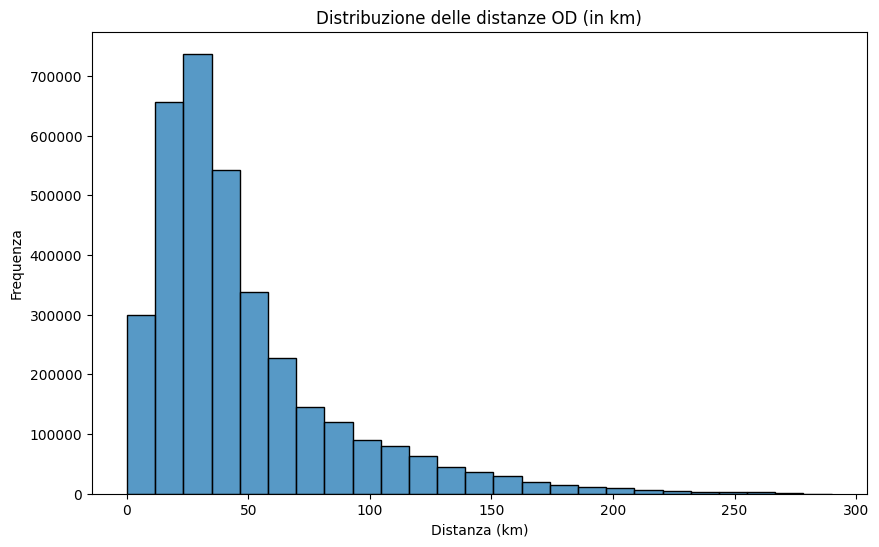

In [59]:
# Istogramma generale
plt.figure(figsize=(10,6))
sns.histplot(df['distance_km'], bins=25, kde=False)
plt.title("Distribuzione delle distanze OD (in km)")
plt.xlabel("Distanza (km)")
plt.ylabel("Frequenza")
plt.show()

Distanze medie per tutte le categorie

In [64]:

# --- Genere ---
mean_dist_gender = {
    'Uomini': np.average(df['distance_km'], weights=df['uomini']),
    'Donne': np.average(df['distance_km'], weights=df['donne']),
}

# --- Fasce d’età ---
age_labels = ['Minorenni', '18-30', '31-40', '41-50', '51-60', '>60']
age_columns = ['Minorenni', '18-30', '31-40', '41-50', '51-60', '>60']
mean_dist_age = {
    label: np.average(df['distance_km'], weights=df[col])
    for label, col in zip(age_labels, age_columns)
}

# --- Nazionalità ---
mean_dist_nationality = {
    'Italiani': np.average(df['distance_km'], weights=df['italiani']),
    'Stranieri': np.average(df['distance_km'], weights=df['stranieri']),
}

# --- Stampa risultati ---
print("📊 Distanza media per GENERE:")
for k, v in mean_dist_gender.items():
    print(f"  {k}: {v:.2f} km")

print("\n📊 Distanza media per FASCIA D’ETÀ:")
for k, v in mean_dist_age.items():
    print(f"  {k}: {v:.2f} km")

print("\n📊 Distanza media per NAZIONALITÀ:")
for k, v in mean_dist_nationality.items():
    print(f"  {k}: {v:.2f} km")



📊 Distanza media per GENERE:
  Uomini: 14.57 km
  Donne: 13.35 km

📊 Distanza media per FASCIA D’ETÀ:
  Minorenni: 8.35 km
  18-30: 11.29 km
  31-40: 11.45 km
  41-50: 15.49 km
  51-60: 15.30 km
  >60: 14.09 km

📊 Distanza media per NAZIONALITÀ:
  Italiani: 14.17 km
  Stranieri: 11.77 km


Heatmap movimenti tra province

In [98]:
# Crea la matrice OD aggregata 
od_province = (
    df.groupby([
        df['origin'].str.split('|').str[0] + '|' + df['origin'].str.split('|').str[1],
        df['destination'].str.split('|').str[0] + '|' + df['destination'].str.split('|').str[1]
    ])['total_flow']
    .sum()
    .unstack(fill_value=0)
)



In [90]:
prov_map = {
    '08|033': 'Piacenza',
    '08|034': 'Parma',
    '08|035': 'Reggio Emilia',
    '08|036': 'Modena',
    '08|037': 'Bologna',
    '08|038': 'Ferrara',
    '08|039': 'Ravenna',
    '08|040': 'Forlì-Cesena',
    '08|099': 'Rimini'
}
od_province = od_province.rename(index=prov_map, columns=prov_map) / 1000000
od_province

destination,Piacenza,Parma,Reggio Emilia,Modena,Bologna,Ferrara,Ravenna,Forlì-Cesena,Rimini
origin,,,,,,,,,
Piacenza,21.318603,1.335608,0.122739,0.105207,0.149570,0.008972,0.031406,0.026312,0.031327
Parma,1.247800,28.485386,2.673865,0.279472,0.299001,0.021530,0.046903,0.041617,0.046714
Reggio Emilia,0.086336,2.731423,30.012900,4.936220,0.440424,0.034444,0.070629,0.043243,0.048704
Modena,0.076145,0.333237,4.872915,43.723647,4.192619,0.610106,0.178476,0.105825,0.112295
Bologna,0.083023,0.307141,0.400673,3.972843,65.136890,2.320212,2.683515,0.677080,0.509278
Ferrara,0.007500,0.026193,0.034927,0.598183,2.375789,15.600764,0.947479,0.071767,0.046948
Ravenna,0.029271,0.087115,0.088873,0.224165,2.935360,0.929742,23.278223,4.175208,0.640101
Forlì-Cesena,0.019477,0.061198,0.046186,0.127489,0.775695,0.073668,4.227537,23.707445,3.595091
Rimini,0.023570,0.061276,0.048477,0.127737,0.532621,0.046575,0.650985,3.544153,28.921850


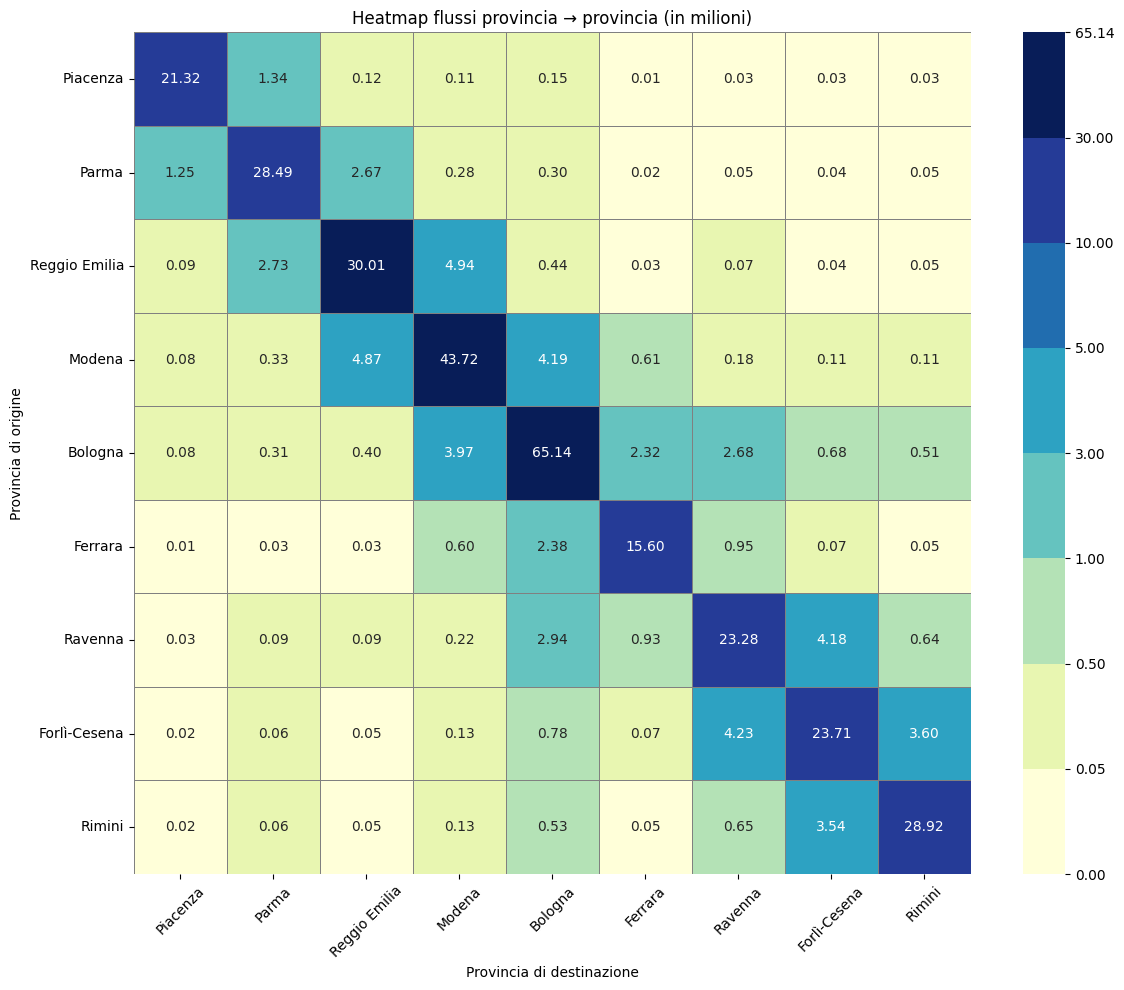

In [96]:
from matplotlib.colors import BoundaryNorm
boundaries = [0, 0.05, 0.5, 1, 3, 5, 10, 30, od_province.values.max()]
norm = BoundaryNorm(boundaries, ncolors=256, clip=True)


plt.figure(figsize=(12, 10))
sns.heatmap(
    od_province_milioni,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".2f",
    norm=norm
)
plt.title('Heatmap flussi provincia → provincia (in milioni)')
plt.xlabel('Provincia di destinazione')
plt.ylabel('Provincia di origine')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


ANALISI INGRESSI DA FUORI REGIONE
siccome non abbiamo dati di ingressi da fuori regione facciamo bilancio flussi per ogni ace -> se riceve piu persone di quante ne invia puo indicare ingressi da fuori regione

In [190]:
# Arrivi e partenze per ACE e data
arrivi = (
    df.groupby(['date', 'destination'])['total_flow']
    .sum()
    .reset_index()
    .rename(columns={'destination': 'ace'})
)
partenze = (
    df.groupby(['date', 'origin'])['total_flow']
    .sum()
    .reset_index()
    .rename(columns={'origin': 'ace'})
)
# Unione su 'date' e 'ace'
bilancio = pd.merge(
    arrivi,
    partenze,
    on=['date', 'ace'],
    how='outer',
    suffixes=('_arrivi', '_partenze')
)

# Riempi NaN con 0
bilancio = bilancio.fillna(0)

# Calcolo bilancio netto
bilancio['bilancio_netto'] = bilancio['total_flow_arrivi'] - bilancio['total_flow_partenze']

# Facoltativo: ordina per data o per valore
bilancio = bilancio.sort_values(['date', 'bilancio_netto'], ascending=[True, False])



In [191]:
bilancio

,date,ace,total_flow_arrivi,total_flow_partenze,bilancio_netto
243,2019-08-01,08|037|006|001|081,19969,0.0,19969.0
446,2019-08-01,08|099|014|001|005,22037,11471.0,10566.0
447,2019-08-01,08|099|014|001|007,20274,9755.0,10519.0
332,2019-08-01,08|038|006|000|000,25868,20014.0,5854.0
146,2019-08-01,08|035|033|002|000,73014,67284.0,5730.0
...,...,...,...,...,...
28477,2019-09-30,08|099|018|000|000,30107,35917.0,-5810.0
28386,2019-09-30,08|039|007|000|000,19211,26519.0,-7308.0
28422,2019-09-30,08|040|012|000|000,53922,62915.0,-8993.0
28055,2019-09-30,08|033|032|000|004,40188,50120.0,-9932.0


In [194]:
# Calcola lo scostamento dalla media per ogni ACE 
bilancio['scostamento'] = (bilancio['bilancio_netto'] - bilancio.groupby('ace')['bilancio_netto'].transform('mean')).abs()

bilancio = bilancio.sort_values('scostamento', ascending=False)
bilancio

,date,ace,total_flow_arrivi,total_flow_partenze,bilancio_netto,scostamento
6449,2019-08-14,08|039|014|001|000,129727,98356.0,31371.0,28381.163934
21860,2019-09-16,08|039|014|001|000,90758,112509.0,-21751.0,24740.836066
16061,2019-09-04,08|036|013|000|000,24984,0.0,24984.0,24159.573770
16053,2019-09-04,08|036|006|000|000,22545,0.0,22545.0,23605.819672
21382,2019-09-15,08|039|007|000|001,38085,64064.0,-25979.0,23568.295082
...,...,...,...,...,...,...
10245,2019-08-22,08|099|009|000|000,348,324.0,24.0,0.098361
23321,2019-09-19,08|099|009|000|000,270,246.0,24.0,0.098361
1839,2019-08-04,08|099|009|000|000,363,339.0,24.0,0.098361
8872,2019-08-19,08|099|027|000|000,2203,2412.0,-209.0,0.032787


In [196]:
def trova_picco_singola_ace(df_bilancio, ace_id):
    """
    Restituisce la riga del DataFrame in cui la ACE specificata ha il maggiore scostamento dalla sua media.
    
    Parametri:
        df_bilancio (DataFrame): il DataFrame con colonne 'ace', 'bilancio_netto'
        ace_id (str): il codice ACE (es. '08|039|014|001|000')

    Ritorna:
        Serie Pandas con i dati del giorno con massimo scostamento
    """
    # Filtro per ACE selezionata
    df_ace = df_bilancio[df_bilancio['ace'] == ace_id].copy()

    if df_ace.empty:
        return f"Nessuna riga trovata per ACE: {ace_id}"

    # Calcolo media e scostamento
    media = df_ace['bilancio_netto'].mean()
    df_ace['scostamento'] = (df_ace['bilancio_netto'] - media).abs()

    # Ritorna la riga con lo scostamento massimo
    return df_ace.loc[df_ace['scostamento'].idxmax()]


In [214]:
picco = trova_picco_singola_ace(bilancio, '08|037|032|000|001')
print(picco)

date                           2019-09-07
ace                    08|037|032|000|001
total_flow_arrivi                   16479
total_flow_partenze               20103.0
bilancio_netto                    -3624.0
scostamento                   3908.213115
Name: 17572, dtype: object
